# Correlation analysis 

In [1]:
import sys
import pathlib
import warnings
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

sys.path.append("../../../")
from utils import data_utils

# ignore all warnings
warnings.filterwarnings("ignore")

# setting seed for reproducibility
np.random.seed(0)

Helper functions

In [2]:
def update_dmso_pathway_label(treatment: str, pathway: str) -> str:
    """
    Update the pathway label for wells treated with DMSO.

    Wells treated with DMSO do not have a specific pathway label. This function assigns
    a pathway label based on the type of DMSO treatment: "DMSO-positive" or "DMSO-negative".
    For other treatments, the original pathway label is retained.

    Parameters
    ----------
    treatment : str
        The treatment type, e.g., "DMSO-positive" or "DMSO-negative".
    pathway : str
        The current pathway label.

    Returns
    -------
    str
        The updated pathway label. If the treatment is "DMSO-positive" or "DMSO-negative",
        the pathway label is updated to match the treatment type. Otherwise, the original
        pathway label is returned unchanged.
    """
    if treatment == "DMSO-positive":
        return "DMSO-positive"
    elif treatment == "DMSO-negative":
        return "DMSO-negative"
    else:
        return pathway

Loading the data 

In [3]:
data_path = pathlib.Path("../UMAP-aggregated-fs-profiles/results/concat_data/batch_1_concat_agg_fs.csv")

# setting output path
output_path = pathlib.Path("results/")
output_path.mkdir(parents=True, exist_ok=True)

In [4]:
# load the data 
concat_profile_df = pd.read_csv(data_path)

# update the Pathway label for wells treated with DMSO
concat_profile_df["Metadata_Pathway"] = concat_profile_df.apply(
	lambda row: update_dmso_pathway_label(row["Metadata_treatment"], row["Metadata_Pathway"]), axis=1
)

concat_profile_df["Metadata_Pathway"].replace("nan", "No Pathway", inplace=True)


# split the data into metadata and features
meta_cols, feat_cols = data_utils.split_meta_and_features(concat_profile_df)

concat_profile_df.head()

,Metadata_plate_barcode,Metadata_plate_name,Metadata_control_type,Metadata_WellRow,Metadata_WellCol,Metadata_heart_number,Metadata_cell_type,Metadata_heart_failure_type,Metadata_treatment,Metadata_Pathway,...,Nuclei_Texture_InfoMeas2_PM_3_03_256,Nuclei_Texture_InverseDifferenceMoment_Hoechst_3_00_256,Nuclei_Texture_InverseDifferenceMoment_Hoechst_3_01_256,Nuclei_Texture_InverseDifferenceMoment_Hoechst_3_02_256,Nuclei_Texture_InverseDifferenceMoment_Hoechst_3_03_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_00_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_01_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_02_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_03_256,Nuclei_Texture_SumEntropy_PM_3_01_256
0,localhost240927060001,plate_1,positive,B,2,7,healthy,NaN,DMSO-positive,DMSO-positive,...,0.340226,-0.397719,-0.554410,-0.597032,-0.599841,-0.452233,-0.512690,-0.479060,-0.487456,0.377711
1,localhost240927060001,plate_1,trt,B,3,19,failing,dilated_cardiomyopathy,UCD-0159256,Apoptosis,...,0.426732,0.192443,0.201591,0.193599,0.207943,-0.591082,-0.595971,-0.438921,-0.572451,0.509203
2,localhost240927060001,plate_1,trt,B,4,19,failing,dilated_cardiomyopathy,UCD-0001766,Angiogenesis,...,0.970090,-0.780760,-0.846263,-0.654640,-0.655297,-1.282220,-1.381008,-1.344134,-1.241213,1.432368
3,localhost240927060001,plate_1,positive,B,5,7,healthy,NaN,DMSO-positive,DMSO-positive,...,0.218604,-0.125840,-0.107253,-0.217232,-0.302984,-0.218122,-0.285449,-0.181189,-0.307638,0.227360
4,localhost240927060001,plate_1,trt,B,6,19,failing,dilated_cardiomyopathy,UCD-0159262,Others,...,1.039161,-1.043130,-1.173101,-1.073500,-0.994948,-1.680824,-1.553425,-1.727551,-1.443283,1.551807


## Calculating correlation of each samples

In this section fo the notebook, we build on our Pearson correlation analysis by visualizing the data with a seaborn clustermap. With each treatment linked to a specific pathway target, the clustergram not only groups samples based on morphological similarity but also allows us to observe whether treatments targeting the same pathway exhibit similar phenotypic profiles. This integrative approach provides insights into how specific pathway interventions drive morphological changes, thereby enhancing our biological interpretation of the treatment effects.

In [5]:
# creating a dataframe with only the pathway and morphological features
pathway_df = concat_profile_df[["Metadata_treatment", "Metadata_Pathway"] + feat_cols]

# Replace invalid or missing values in the "Metadata_Pathway" column using apply()
pathway_df["Metadata_Pathway"] = pathway_df["Metadata_Pathway"].apply(
    lambda x: "No Pathway" if pd.isna(x) or x in ["NaN", "nan"] else x
)

# creating a dataframe with only morphological features
morph_df = pathway_df[feat_cols].copy()

# Calculate the pearson correlation between treated samples (well-level profiles)
sample_corr_matrix = morph_df.T.corr(method="pearson")

sample_corr_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,210,211,212,213,214,215,216,217,218,219
0,1.000000,0.335277,0.243445,0.801070,0.389125,0.092725,0.799546,-0.169060,0.266378,0.638006,...,-0.045777,-0.224643,-0.157653,-0.056838,-0.206850,-0.169738,-0.021696,-0.020464,0.057737,0.007141
1,0.335277,1.000000,-0.184241,0.365439,-0.219379,-0.021105,0.414099,-0.100078,0.051071,0.526365,...,0.309041,-0.090873,0.099346,0.102038,-0.313753,0.066340,0.204233,0.165197,0.405956,0.137175
2,0.243445,-0.184241,1.000000,0.240265,0.745279,0.540318,0.244842,0.202549,0.744367,0.096247,...,-0.326904,-0.339092,-0.444671,-0.452349,-0.265333,-0.569539,-0.574145,-0.508927,-0.505415,-0.469846
3,0.801070,0.365439,0.240265,1.000000,0.380240,0.134678,0.855341,-0.148986,0.319988,0.628624,...,-0.028331,-0.234762,-0.085380,-0.061394,-0.286016,-0.084102,0.007379,0.030774,0.147989,0.069640
4,0.389125,-0.219379,0.745279,0.380240,1.000000,0.564174,0.414995,0.040720,0.661800,0.255021,...,-0.342149,-0.270663,-0.363822,-0.334742,-0.082423,-0.367712,-0.466376,-0.453175,-0.454985,-0.321764


With the correlation matrix generated by calculating the correlation by each sample, then we create a clustergram where the axis represents the pathway of each treament, and the color gradient represents the correlation between samples.With the correlation matrix computed from each sample’s morphological profile, we generate a clustergram using seaborn. In this visualization, the axes are annotated with the pathway targets associated with each treatment, while the color gradient reflects the strength of the correlation between samples, enabling us to identify clusters of treatments with similar phenotypic responses.

<Figure size 1200x1200 with 0 Axes>

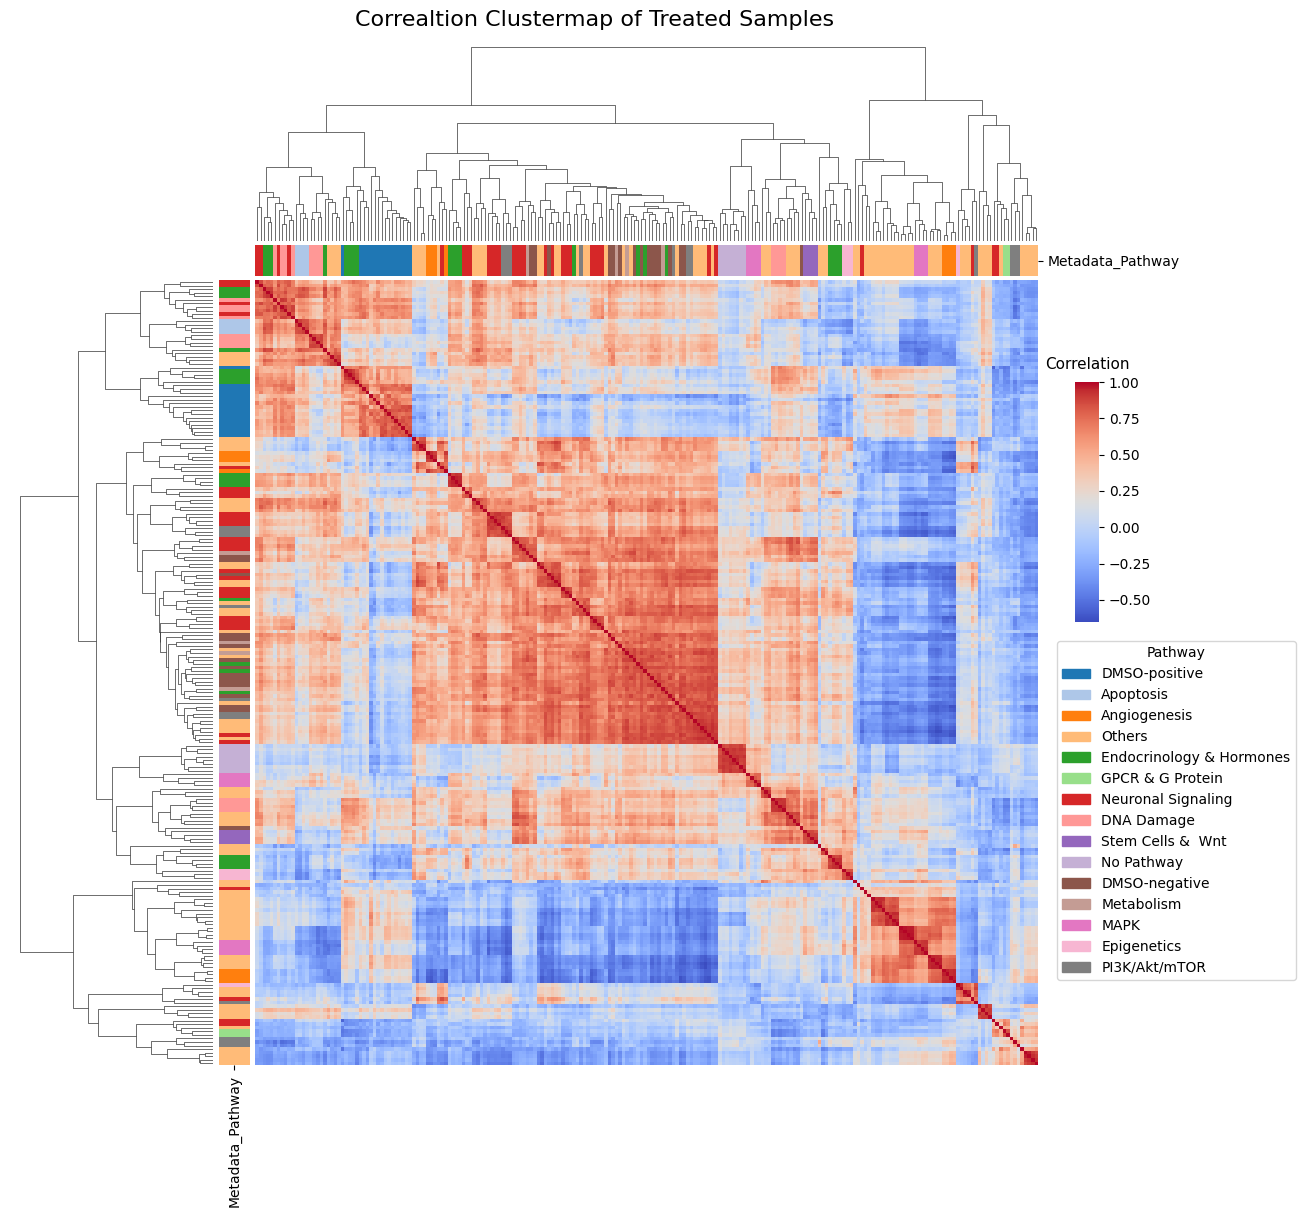

In [6]:
# plot the correlation matrix
plt.figure(figsize=(12, 12))

# create a color bar for the unique pathways
unique_pathways = pathway_df["Metadata_Pathway"].unique()
pathway_colors = sns.color_palette("tab20", len(unique_pathways))
pathway_color_dict = dict(zip(unique_pathways, pathway_colors))


# create a color map for the treatments
pathway_color_map = pathway_df["Metadata_Pathway"].map(pathway_color_dict)

# using seaborn, plot a clustermap 
sample_corr_clustermap = sns.clustermap(
    sample_corr_matrix,
    row_colors=pathway_color_map,
    col_colors=pathway_color_map,
    cmap="coolwarm",
    figsize=(12, 12),
    xticklabels=1,
    yticklabels=1,
    cbar_pos=(0.90, 0.50, 0.02, 0.2)
)

# adding title to the clustermap figure
sample_corr_clustermap.fig.suptitle("Correaltion Clustermap of Treated Samples", fontsize=16, y=1.01)

# remove x and y ticks and labels
sample_corr_clustermap.ax_heatmap.set_xticklabels([])
sample_corr_clustermap.ax_heatmap.set_yticklabels([])
sample_corr_clustermap.ax_heatmap.set_xticks([])
sample_corr_clustermap.ax_heatmap.set_yticks([])

# adding the Pathway legend to the cluster map
handles = [mpatches.Patch(color=color, label=pathway) for pathway, color in pathway_color_dict.items()]
sample_corr_clustermap.fig.legend(handles=handles, title="Pathway", loc="upper right", bbox_to_anchor=(1.09, 0.49))

# now taking the colobar legend and adding a title
cbar = sample_corr_clustermap.ax_heatmap.collections[0].colorbar
cbar.ax.set_title("Correlation", fontsize=11, x=0.5, y=1.02)

# save the figure
output_file = output_path / "sample_corr_clustermap.png"
sample_corr_clustermap.savefig(output_file, dpi=500, bbox_inches="tight")

sample_corr_clustermap;

## Correlation matrix sorted by treatment name

In [7]:
# calculate the correlation 
concat_profile_df = concat_profile_df.sort_values(by=["Metadata_treatment"])
sorted_morph_df = concat_profile_df[feat_cols].copy()
sorted_df_measurement_labels = [colname.split("_")[1] for colname in sorted_morph_df.columns]

# calculate the correlation matrix for the sorted dataframe
sorted_treatment_corr_matrix = sorted_morph_df.corr(method="pearson")

<Figure size 1200x1200 with 0 Axes>

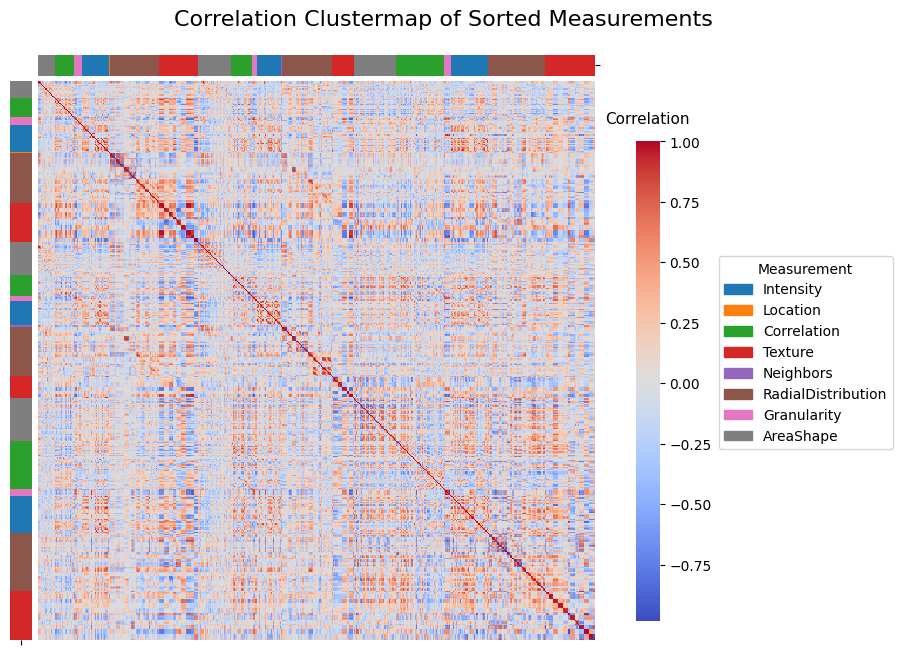

In [8]:
# setting the figure size
plt.figure(figsize=(12, 12))

# creating a color bar for the unique measurement labels
unique_measurements = list(set(sorted_df_measurement_labels))
sorted_measurement_colors = sns.color_palette("tab10", len(unique_measurements))
sorted_measurement_color_dict = dict(zip(unique_measurements, sorted_measurement_colors))


# create a color map for the treatments
measurement_color_map = pd.Series(
    sorted_df_measurement_labels, 
    index=sorted_treatment_corr_matrix.index
).map(sorted_measurement_color_dict)


# Plotting the sorted correlation matrix
sorted_treatment_corr_clustermap = sns.clustermap(
    sorted_treatment_corr_matrix,
    row_colors=measurement_color_map,
    col_colors=measurement_color_map,
    cmap="coolwarm",
    figsize=(12, 12),
    xticklabels=1,
    yticklabels=1,
    col_cluster=False,
    row_cluster=False,
)

# removing x and y ticks and labels
sorted_treatment_corr_clustermap.ax_heatmap.set_xticklabels([])
sorted_treatment_corr_clustermap.ax_heatmap.set_yticklabels([])
sorted_treatment_corr_clustermap.ax_heatmap.set_xticks([])
sorted_treatment_corr_clustermap.ax_heatmap.set_yticks([])

# removing the dendogram padding (the padding is still there, but not visible)
sorted_treatment_corr_clustermap.ax_row_dendrogram.set_visible(False)
sorted_treatment_corr_clustermap.ax_col_dendrogram.set_visible(False)

# adding title to the clustermap figure
sorted_treatment_corr_clustermap.fig.suptitle("Correlation Clustermap of Sorted Measurements", fontsize=16, y=0.9)


# adding the Measurement legend to the cluster map
handles = [mpatches.Patch(color=color, label=measurement) for measurement, color in sorted_measurement_color_dict.items()]
sorted_treatment_corr_clustermap.fig.legend(handles=handles, title="Measurement", loc="upper right", bbox_to_anchor=(.88, .7))


# now taking the colobar legend and adding a title
cbar = sorted_treatment_corr_clustermap.ax_heatmap.collections[0].colorbar
cbar.ax.set_title("Correlation", fontsize=11, x=0.5, y=1.02)
cbar.ax.set_position([0.66, 0.39, 0.02, 0.4])

# save the correlation heatmap
plt.savefig(output_path / "correlation_morph_sorted_treatments.png", dpi=500)

# display the sorted treatment correlation clustermap
sorted_treatment_corr_clustermap;


## Correlation cluster gram of morphological features

In [9]:
morph_df = concat_profile_df[feat_cols].copy()
morph_labels = [colname.split("_")[0] for colname in feat_cols]
measurement_labels = [colname.split("_")[1] for colname in feat_cols]
corr_morph_df = morph_df.corr(method="pearson")

<Figure size 1200x1200 with 0 Axes>

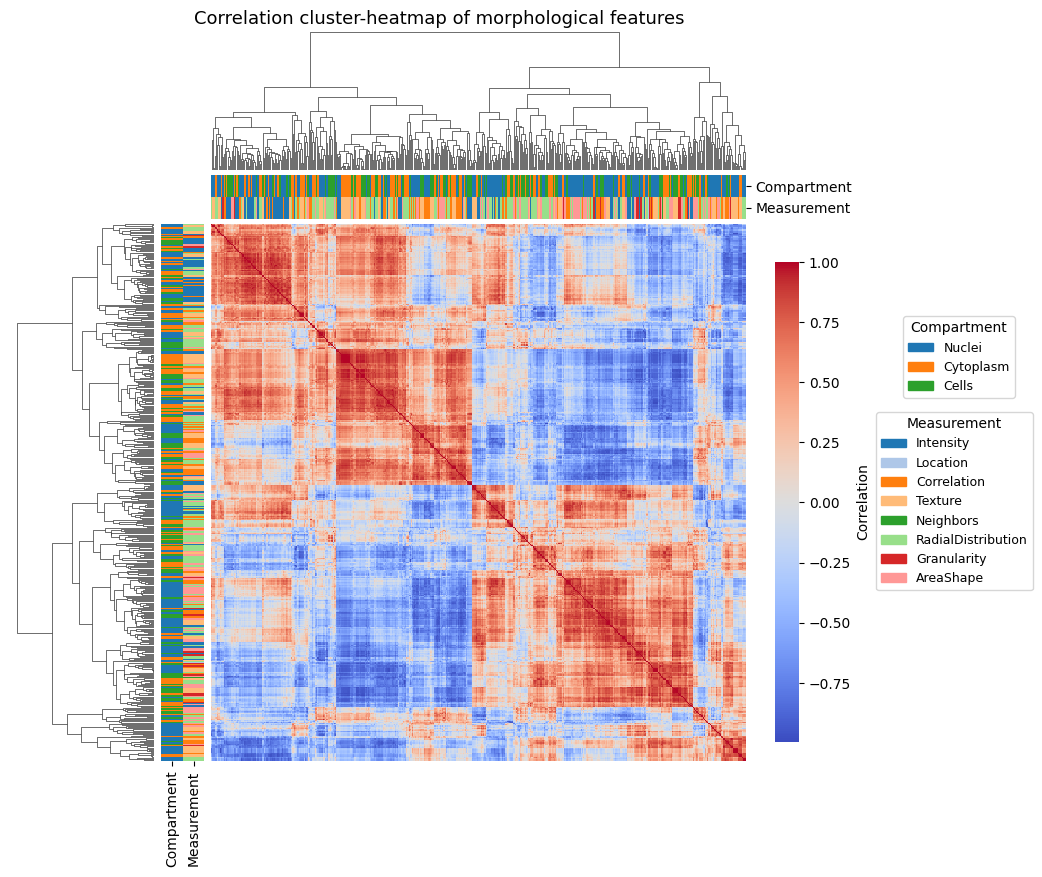

In [10]:
# setting figure size
plt.figure(figsize=(12, 12))

# Create the color maps (already defined)
unique_morph_labels = list(set(morph_labels))
morph_colors = sns.color_palette("tab10", len(unique_morph_labels))
morph_color_dict = dict(zip(unique_morph_labels, morph_colors))

unique_measurement_labels = list(set(measurement_labels))
measurement_colors = sns.color_palette("tab20", len(unique_measurement_labels))
measurement_color_dict = dict(zip(unique_measurement_labels, measurement_colors))

# create a color map for the morphological features and measurement types
morph_color_map = pd.Series(morph_labels, index=feat_cols).map(morph_color_dict)
measurement_color_map = pd.Series(measurement_labels, index=feat_cols).map(lambda x: measurement_color_dict.get(x, None))

# combine the two color maps
row_and_col_color_map = pd.DataFrame(
    {"Compartment": morph_color_map, 
     "Measurement": measurement_color_map}
)

# generate seaborn clustermap with a larger figure size
clustermap = sns.clustermap(
    corr_morph_df.corr(method="pearson"),
    cmap="coolwarm",
    # row_colors=morph_color_map,
    # col_colors=morph_color_map,
    row_colors=row_and_col_color_map,
    col_colors=row_and_col_color_map,
    figsize=(12, 12),
    xticklabels=1,
    yticklabels=1,
)

# next remove the X and Y axis labels for better visualization and ticks
clustermap.ax_heatmap.set(xticklabels=[])
clustermap.ax_heatmap.set(yticklabels=[])
clustermap.ax_heatmap.set_xticks([])
clustermap.ax_heatmap.set_yticks([])

# Set the title of the clustermap
clustermap.fig.suptitle("Correlation cluster-heatmap of morphological features", x=0.37, y=1., fontsize=13)

# adding the Morphological features legend to the cluster map
handles = [mpatches.Patch(color=color, label=label) for label, color in morph_color_dict.items()]
clustermap.fig.legend(handles=handles, title="Compartment", loc="upper right", bbox_to_anchor=(.855, .75), fontsize=9)

# adding the Measurement type legend to the cluster map
handles = [mpatches.Patch(color=color, label=label) for label, color in measurement_color_dict.items()]
clustermap.fig.legend(handles=handles, title="Measurement", loc="upper right", bbox_to_anchor=(.87, .67), fontsize=9)

# move color gradient to the left side 
clustermap.ax_heatmap.collections[0].colorbar.set_label("Correlation")
clustermap.cax.set_position([0.65, 0.39, 0.02, 0.4])


# save the clustermap to a file
clustermap.savefig(output_path / "clustermap_morph_features.png", dpi=500)
clustermap;
